### Import thư viện và dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
 
path = "Dataset" 
labelFile = 'labels.csv' 
batch_size_val=32 
epochs_val=12
imageDimesions = (32,32,3)
testRatio = 0.2    
validationRatio = 0.2 

count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Tổng số nhãn được phát hiện:",len(myList))
noOfClasses=len(myList)
print("Đang khởi tạo.....")
for x in range (0,len(myList)):
    myPicList = os.listdir(path+"/"+str(count))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(count)+"/"+y)
        images.append(curImg)
        classNo.append(count)
    print(count, end =" ")
    count +=1
print(" ")
images = np.array(images)
classNo = np.array(classNo)
 
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)
 

print("Data Shapes")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
print("Test",end = "");print(X_test.shape,y_test.shape)


data=pd.read_csv(labelFile)
print("data shape ",data.shape,type(data))

Tổng số nhãn được phát hiện: 43
Đang khởi tạo.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  
Data Shapes
Train(22271, 32, 32, 3) (22271,)
Validation(5568, 32, 32, 3) (5568,)
Test(6960, 32, 32, 3) (6960,)
data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


### Kiểm tra dataset

[119, 1266, 1282, 802, 1164, 1052, 226, 804, 782, 808, 1153, 757, 1207, 1226, 430, 350, 238, 626, 688, 128, 202, 164, 221, 291, 162, 860, 344, 140, 320, 164, 250, 439, 140, 389, 232, 670, 208, 114, 1213, 164, 201, 139, 136]


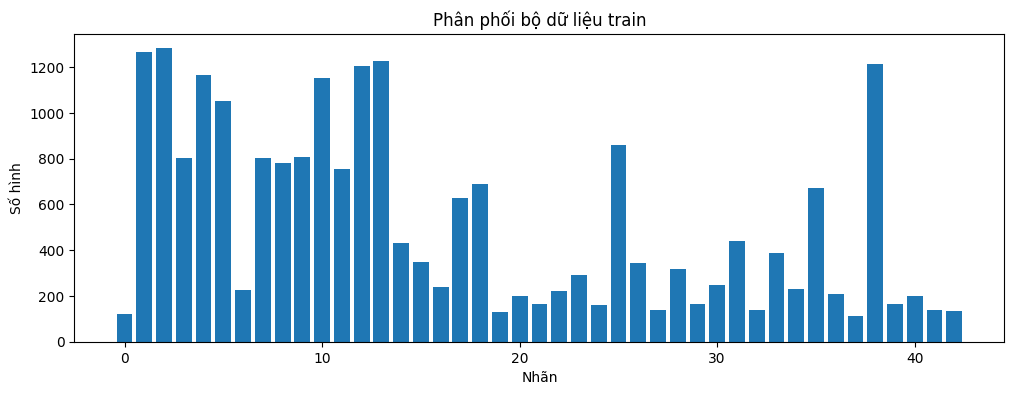

In [3]:
#Hiển thị phân phối số hình trong từng nhãn
num_of_samples = []
cols = 5
num_classes = noOfClasses

for j, row in data.iterrows():
    x_selected = X_train[y_train == j]
    num_of_samples.append(len(x_selected))

#Biểu đồ phân phối
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Phân phối bộ dữ liệu train")
plt.xlabel("Nhãn")
plt.ylabel("Số hình")
plt.show()

### Tiền xử lý

In [4]:

def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img =cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)     
    img = equalize(img)      
    img = img/255            
    return img
 
X_train=np.array(list(map(preprocessing,X_train)))  
X_validation=np.array(list(map(preprocessing,X_validation)))
X_test=np.array(list(map(preprocessing,X_test)))


X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
 
 
dataGen= ImageDataGenerator(width_shift_range=0.1,   
                            height_shift_range=0.1,
                            zoom_range=0.2,  
                            shear_range=0.1,  
                            rotation_range=10)  
dataGen.fit(X_train)
batches= dataGen.flow(X_train,y_train,batch_size=20)
X_batch,y_batch = next(batches)
 

y_train = to_categorical(y_train,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)

### Train model

In [5]:
def myModel():
    model= Sequential()
    model.add((Conv2D(60,(5,5),input_shape=(imageDimesions[0],imageDimesions[1],1),activation='relu')))
    model.add((Conv2D(60, (5,5), activation='relu')))
    model.add(MaxPooling2D(pool_size=(2,2)))
 
    model.add((Conv2D(30, (3,3),activation='relu')))
    model.add((Conv2D(30, (3,3), activation='relu')))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
 
    model.add(Flatten())
    model.add(Dense(500,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses,activation='softmax')) 
    model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 60)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 30)          0         
 g2D)                                                   

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10916\148294848.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(dataGen.flow(X_train,y_train,batch_size=32),steps_per_epoch=len(X_train)//32,epochs=epochs_val,validation_data=(X_validation,y_validation),shuffle=1)


695/695 [==============================] - 93s 132ms/step - loss: 2.3043 - accuracy: 0.3542 - val_loss: 0.6673 - val_accuracy: 0.7911
Epoch 2/12
695/695 [==============================] - 102s 147ms/step - loss: 1.1149 - accuracy: 0.6583 - val_loss: 0.3105 - val_accuracy: 0.9174
Epoch 3/12
695/695 [==============================] - 98s 141ms/step - loss: 0.7637 - accuracy: 0.7630 - val_loss: 0.1581 - val_accuracy: 0.9641
Epoch 4/12
695/695 [==============================] - 95s 137ms/step - loss: 0.6040 - accuracy: 0.8111 - val_loss: 0.1132 - val_accuracy: 0.9705
Epoch 5/12
695/695 [==============================] - 96s 138ms/step - loss: 0.4935 - accuracy: 0.8445 - val_loss: 0.0896 - val_accuracy: 0.9781
Epoch 6/12
695/695 [==============================] - 92s 133ms/step - loss: 0.4381 - accuracy: 0.8620 - val_loss: 0.0789 - val_accuracy: 0.9795
Epoch 7/12
695/695 [==============================] - 92s 132ms/step - loss: 0.3863 - accuracy: 0.8769 - val_loss: 0.0773 - val_accuracy: 0.

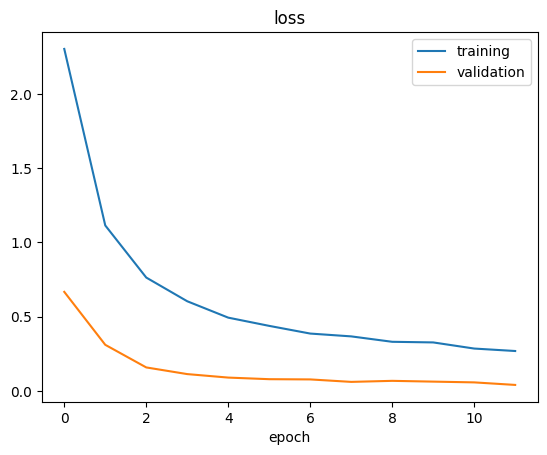

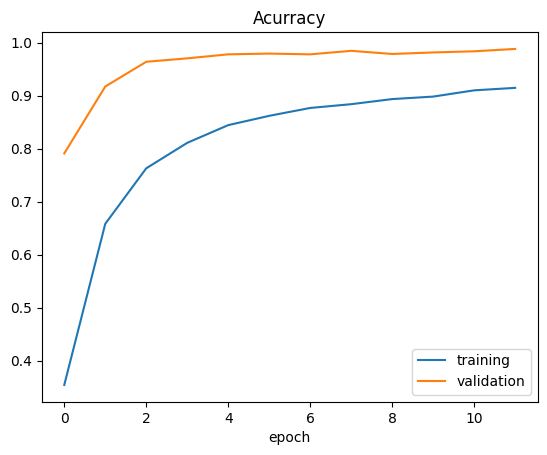

Test Score: 0.039055198431015015
Test Accuracy: 0.9893678426742554


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
model = myModel()
print(model.summary())
history=model.fit_generator(dataGen.flow(X_train,y_train,batch_size=32),steps_per_epoch=len(X_train)//32,epochs=epochs_val,validation_data=(X_validation,y_validation),shuffle=1)

plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score =model.evaluate(X_test,y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])
 
model.save("model.h5")